In [1]:
from collections import Counter, namedtuple
from IPython.display import clear_output, display
from tqdm import tqdm_notebook as tqdm
from util import (
    calculate_score,
    feature_to_target,
    load_data,
    target_to_feature,
    
    DF_TARGETS,
    DF_FEATURES
)

import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

TRAIN_FILE = './data/train.csv'
TEST_FILE = './data/test.csv'
RANDOM_STATE = 42

In [2]:
train_df, test_df = load_data(TRAIN_FILE, TEST_FILE, None, None)
train_df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [3]:
ANOMALY_THRESHOLD = 15

def get_sat_data(df, sat_id):
    return df[df.sat_id == sat_id]

def count_time_deltas(sat_df):
    ts = sat_df.epoch.values
    time_deltas = ts[1:] - ts[:-1]
    return Counter(time_deltas)

def merge_train_and_test_as_stupid(train_df, test_df):
    columns = ['id', 'epoch', 'sat_id'] + DF_FEATURES
    all_df = pd.concat([train_df[columns], test_df])
    all_df.reset_index(drop=True, inplace=True)
    all_df.sort_values(by=['sat_id', 'epoch'], inplace=True)
    return all_df

def do_stupid_predictions(all_df, anomaly_time_delta=np.timedelta64(1, 'm')):
    result = []
    for sat_id, df in all_df.groupby('sat_id'):
        n_measurements = df.shape[0]
        features = df[DF_FEATURES].values
        targets = features
        dts = df.epoch.values[1:] - df.epoch.values[:-1]
        has_anomalies = np.any(dts <= anomaly_time_delta)
        if has_anomalies:
            anomaly_ids = np.arange(features.shape[0])[np.hstack([[False], dts < anomaly_time_delta])]
            n_anomaly = 0
            n_cutted = 0
            prev_anomaly_id = 0
            blocks = []
            for anomaly_id in anomaly_ids:
                rel_anomaly_id = anomaly_id - n_cutted - n_anomaly
                new_block, features = np.split(features, [rel_anomaly_id])
                blocks.extend([new_block, new_block[-1:]])
                prev_anomaly_id = anomaly_id
                n_anomaly += 1
                n_cutted += new_block.shape[0]
            if features.shape[0] > 0:
                blocks.append(features)
            targets = np.vstack(blocks)
            n_new_measurements = targets.shape[0] - n_measurements
            targets = targets[:-n_new_measurements]
        targets = pd.DataFrame(targets, columns=DF_TARGETS)
        df = df[['id', 'epoch', 'sat_id']].copy()
        df.reset_index(drop=True, inplace=True)
        result.append(pd.concat([df, targets], axis=1))
    return pd.concat(result)

In [4]:
%%time
all_df = merge_train_and_test_as_stupid(train_df, test_df)
shifted_sim = do_stupid_predictions(all_df)
shifted_sim

Wall time: 4.98 s


,id,epoch,sat_id,x,y,z,Vx,Vy,Vz
0,0,2014-01-01 00:00:00.000,0,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01 00:46:43.000,0,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01 01:33:26.001,0,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01 02:20:09.001,0,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01 03:06:52.002,0,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237
...,...,...,...,...,...,...,...,...,...
1792,1234089,2014-01-31 22:00:22.602,599,-20717.958996,-16245.240500,5250.939232,-1.653931,3.157321,0.079069
1793,1234090,2014-01-31 22:25:13.240,599,-22673.444496,-11192.339393,5243.608790,-0.945328,3.603371,-0.092202
1794,1234091,2014-01-31 22:50:03.878,599,-23461.830699,-5570.167175,4966.813869,-0.087089,3.912550,-0.281989
1795,1234092,2014-01-31 23:14:54.515,599,-22858.679929,373.249102,4396.055679,0.920162,4.021955,-0.485364


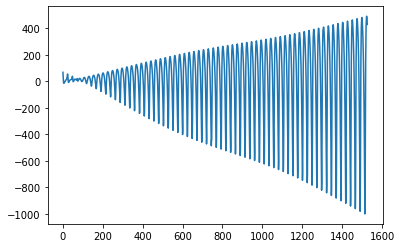

In [6]:
SAT_ID = 18
VAR = 'x'

sat_df = get_sat_data(train_df, SAT_ID)[['id', 'epoch', 'sat_id'] + DF_TARGETS]
to_check_sim = shifted_sim.copy()
to_check_sim.columns = ['id', 'epoch', 'sat_id'] + DF_FEATURES
to_check_train = sat_df.merge(to_check_sim, how='inner', on='id')
plt.plot(to_check_train[VAR].values - to_check_train[target_to_feature(VAR)].values)

In [345]:
stupid_df = test_df.merge(shifted_sim, how='inner', on='id')
stupid_df[['id'] + DF_TARGETS].to_csv('./predictions/stupid_solution_2.csv', index=False)

# Let's create clean dataset

In [7]:
to_save_sim = shifted_sim.copy()
to_save_sim.columns = ['id', 'epoch', 'sat_id'] + DF_FEATURES
to_save_sim = to_save_sim[['id'] + DF_FEATURES]

to_save_train = train_df[['id', 'epoch', 'sat_id'] + DF_TARGETS]
clean_train_df = to_save_train.merge(to_save_sim, how='inner', on='id')
clean_train_df.to_csv('./data/train_clean.csv', index=False)

to_save_test = test_df[['id', 'epoch', 'sat_id']]
clean_test_df = to_save_sim.merge(to_save_test, how='inner', on='id')
clean_test_df.to_csv('./data/test_clean.csv', index=False)